In [ ]:
!pip install tensorflow==2.4.1
!pip install tensorflow-quantum==0.5.1
# Cirq linking seems to be broken, so reinstall the core package
!pip install --no-deps --force-reinstall cirq-core==0.11.0

# **Task III: Part a) implement a quantum variational autoencoder in TF Quantum and show its performance**

### Dataset:
The electron-photon dataset (which can be found here) contains 100 samples for training and another 100 for testing, laid out as follows:

● data["x_train"]: Training dataset of 100 32x32 images containing the particles' energy (100, 32, 32)

● data["y_train"]:" Training labels, 0 = "photon", 1 = "electron" (100,)

● data["x_test"]: Test dataset of 100 32x32 images containing the particles' energy (100, 32, 32)

● data["y_test"]:" Test labels, 0 = "photon", 1 = "electron" (100,)

## **Quantum Variational Autoencoder**

 A limiting factor for nearly
all of quantum applications, is the amount of quantum
resources that can be realized in an experiment. Therefore, for
experiments now and in the near future, any tool which can reduce the experimental overhead in terms of these resources is
especially valuable.This can be done using a technique called autoencoding.
<br>
Quantum Autoencoder is a way of encoding data into a compressed form using suitable training over variational circuits.
<br>
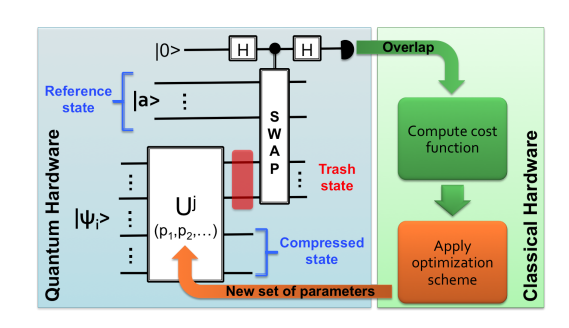
<br>
The approach used to solve this task is inspired from this paper[1] where we use a PQC(Parameterised Quantum Circuit) to perform operations on input data.
After this, we trace out a few data qubits and measure its fidelity with a reference state. The PQC circuit is trained to minimize the fidelity loss between the traced out space and the reference state. After training we can say that we have successfully atleast approximately encoded data into a compressed space called latent space.

In [ ]:
import numpy as np
import sympy
import tensorflow as tf
import tensorflow_quantum as tfq
import cirq
%matplotlib inline
import matplotlib.pyplot as plt
from cirq.contrib.svg import SVGCircuit

# **Dataset Preprocessing**

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving electron-photon.npz to electron-photon.npz


In [ ]:
data = np.load('./electron-photon.npz', allow_pickle = True)

In [ ]:
for key in data.keys():
  print(key)
  print(data[key])
  

x_train
[[[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 ...

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]

 [[0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  ...
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]
  [0. 0. 0. ... 0. 0. 0.]]]
y_

In [ ]:
X_train = data['x_train']
y_train = data['y_train']
X_test = data['x_test']
y_test = data['y_test']

# check
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(100, 32, 32)
(100,)
(100, 32, 32)
(100,)


# Feature Reduction

Each image is of size 32x32 and the information in the image is highly sparse(most of pixels are zero). Also after careful preprocessing it is also evident that a very small ammount of information is actually present in the corner pixels and that is what actually distinguishes two or more images to a larger extent. So cropping the images won't be an option. Here, we will apply a classical subroutine called PCA(Principal Component Analysis) to the input data to reduce the feature dimensions from 1024(32x32 in 2D) to some small number of features that best fits our model.

In [ ]:
from sklearn.decomposition import PCA

n_pca = 10
X_train_flatten = X_train.reshape(-1,32*32)
X_test_flatten = X_test.reshape(-1,32*32)

pca = PCA(n_components = n_pca)
pca.fit(X_train_flatten)

X_train_transform = pca.transform(X_train_flatten)
X_test_transform = pca.transform(X_test_flatten)

#check
print(X_train_transform.shape)
print(X_test_transform.shape)

# Let's check if the pca transform preserves the inherent variance present in this data
print(np.cumsum(pca.explained_variance_ratio_)) 

(100, 10)
(100, 10)
[0.48118138 0.65938324 0.76321054 0.84084606 0.8902277  0.9208717
 0.94699347 0.9600863  0.96964854 0.9764575 ]


We can see that after transforming the data using PCA, the features reduce from 1024 features to 10 features but retains upto ~97% of its variance. However, we can use more features to get better results  from the model 

# **Circuit Architecture**
In this task, we are going to use 10 qubits for the data from the dataset.Along with this we use 6 reference qubits and 1 extra qubit for the Swap Test.Total qubits used will be 17 out of which the last 4 qubits form the latent space in which the compressed encoding of data occurs.

In [ ]:
# Initializing Qubits
qubits = cirq.GridQubit.rect(1,17)
# num_qubits = 9

In [ ]:
# Defining standard unitaries
# encoder unitary
def one_qubit_unitary_enc(bit, symbols):
    """Make a Cirq circuit enacting a rotation of the bloch sphere about the X,
    Y and Z axis, that depends on the values in `symbols`.
    """
    return cirq.Circuit(
        cirq.X(bit)**symbols[0],
        cirq.Y(bit)**symbols[1],
        cirq.Z(bit)**symbols[2])

# decoder unitary
def one_qubit_unitary_dec(bit,symbols):
   """Make a Cirq circuit enacting a rotation of the bloch sphere about the X,
    Y and Z axis, that depends on the values in `symbols`.
    """
   return cirq.Circuit(
        cirq.Z(bit)**symbols[0],
        cirq.Y(bit)**symbols[1],
        cirq.X(bit)**symbols[2]
    )

def two_qubit_unitary(bits, symbols):
    """Make a Cirq circuit that creates an arbitrary two qubit unitary."""
    circuit = cirq.Circuit()
    # circuit += one_qubit_unitary_(bits[0], symbols[0:3])
    # circuit += one_qubit_unitary(bits[1], symbols[3:6])
    circuit += [cirq.ZZ(*bits)**symbols[0]]
    circuit += [cirq.YY(*bits)**symbols[1]]
    circuit += [cirq.XX(*bits)**symbols[2]]
    # circuit += one_qubit_unitary(bits[0], symbols[9:12])
    # circuit += one_qubit_unitary(bits[1], symbols[12:])
    return circuit

In [ ]:
def create_encoder_circuit(qubits,symbols,layers=1):
  circuit = cirq.Circuit()

  for layer in range(layers):
    for i in range(len(qubits)):
      circuit += one_qubit_unitary_enc(qubits[i],symbols[3*i + 3*layer*len(qubits) : 3*(i+1) + 3*layer*len(qubits)])
    
    # for i in range(len(qubits)):
    #   if(i<len(qubits)-1):
    #     circuit += cirq.CNOT(qubits[i],qubits[i+1])
    # circuit += cirq.CNOT(qubits[len(qubits)-1],qubits[0]) 
    for i in range(len(qubits)):
       if(i<len(qubits)-1):
         circuit += two_qubit_unitary(qubits[i:i+2],symbols[3*len(qubits)+3*i + 3*layer*len(qubits) : 3*len(qubits)+3*(i+1) + 3*layer*len(qubits)])

  return circuit

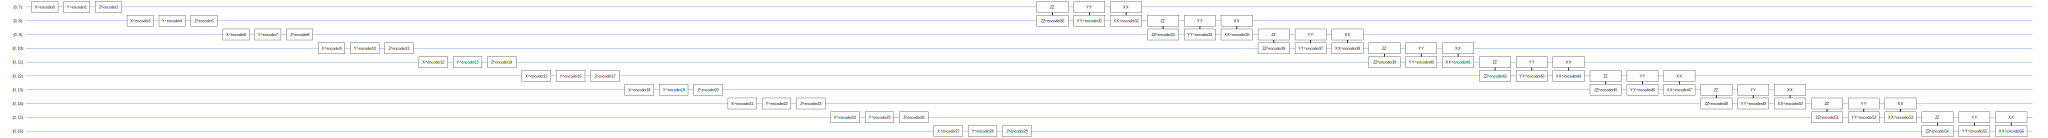

In [ ]:
layers = 1
num_symbols = str(3*len(qubits)*layers*2)
SVGCircuit(create_encoder_circuit(qubits[7:17],sympy.symbols('encoder:'+num_symbols),layers))

In [ ]:
# def create_decoder_circuit(qubits,symbols,layers=1):
#   circuit = cirq.Circuit()

  
#   for layer in range(layers):
#     circuit += cirq.CNOT(qubits[0],qubits[len(qubits)-1])
    
#     for i in range(len(qubits)):
#       if(i<len(qubits)-1):
#         circuit += cirq.CNOT(qubits[len(qubits)-i-1],qubits[len(qubits)-i-2])
    
#     for i in range(len(qubits)):
#       circuit += one_qubit_unitary_dec(qubits[i],symbols[3*i + 3*layer*len(qubits) : 3*(i+1) + 3*layer*len(qubits)])

#   return circuit


In [ ]:
# SVGCircuit(create_decoder_circuit(qubits[0:6]+qubits[11:14],sympy.symbols('decoder:'+num_symbols),layers))

6 6


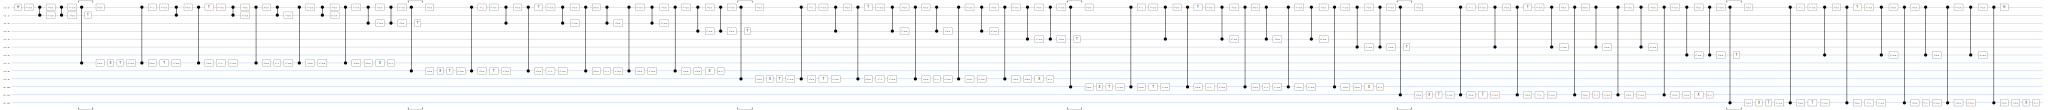

In [ ]:
#swap circuit
def swap_circuit(value_qubit,qubits_ref,qubits_data):
  circuit = cirq.Circuit()
  circuit += cirq.H(value_qubit)
  num_swap_qubits = len(qubits_ref)+len(qubits_data)
  
  for a, b in zip(qubits_ref, qubits_data):
            circuit.append(cirq.decompose(cirq.CSwapGate().on(value_qubit, a, b)))
  circuit += cirq.H(value_qubit)
  return circuit
 
print(len(qubits[1:7]),len(qubits[7:13]))
SVGCircuit(swap_circuit(qubits[0],qubits[1:7],qubits[7:13]))
# SVGCircuit(tfq.from_tensor(swap_circuit(qubits[0:17])))

# Data Encoding

In [ ]:
def generate_quantum_data(X,qubits):
    quantum_data =[]
    for i in X:
        circuit = cirq.Circuit()
        
        for j in range(len(i)):
            circuit.append(cirq.ry(i[j])(qubits[j]))
            
        quantum_data.append(circuit)
    return quantum_data

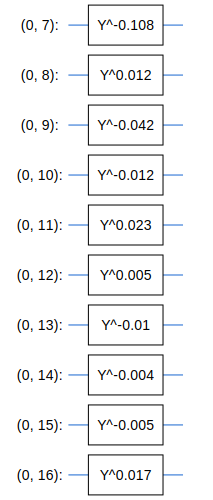

In [ ]:
train_quantum_data = tfq.convert_to_tensor(generate_quantum_data(X_train_transform,qubits[7:17]))
test_quantum_data = tfq.convert_to_tensor(generate_quantum_data(X_test_transform,qubits[7:17]))
SVGCircuit(tfq.from_tensor(train_quantum_data)[0])

In [ ]:
def create_full_circuit(qubits,symbols,layers=1):
  circuit = cirq.Circuit()
  
  circuit += create_encoder_circuit(qubits[7:17],symbols,layers)
  circuit += swap_circuit(qubits[0],qubits[1:7],qubits[7:13])

  return circuit

In [ ]:
create_full_circuit(qubits,sympy.symbols('encoder:'+num_symbols),layers)

┌──┐                                                                                                                                                                                                                  ┌──┐                                                                                                                                                                                                                  ┌──┐                                                                                                                                                                                                                  ┌──┐                                                                                                                                                                                                                  ┌──┐                                                                                                                                                                                                                  ┌──┐
(0, 0): ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────H───Y^-0.5───@───Y^0.5────@───Y^-0.5────@─────Y^0.5────────────────────@───T^-1────Y^-0.5───@────────Y^0.5───@───T───────Y^-0.5───@────────Y^0.5────@───X^0.5───@───────────────@───Y^-0.5───@────────Y^0.5────@───Y^-0.5───@───────Y^0.5────@──────Y^-0.5────@─────Y^0.5────────────────────@───T^-1────Y^-0.5───@────────Y^0.5───@───T───────Y^-0.5───@────────Y^0.5────@───X^0.5───@───────────────@───Y^-0.5───@────────Y^0.5────@───Y^-0.5───@───────Y^0.5────@──────Y^-0.5────@─────Y^0.5────────────────────@───T^-1────Y^-0.5───@────────Y^0.5───@───T───────Y^-0.5───@────────Y^0.5────@───X^0.5───@───────────────@───Y^-0.5───@────────Y^0.5────@───Y^-0.5───@───────Y^0.5────@──────Y^-0.5────@─────Y^0.5────────────────────@───T^-1────Y^-0.5───@────────Y^0.5───@───T───────Y^-0.5───@────────Y^0.5────@───X^0.5───@───────────────@───Y^-0.5───@────────Y^0.5────@───Y^-0.5───@───────Y^0.5────@──────Y^-0.5────@─────Y^0.5────────────────────@───T^-1────Y^-0.5───@────────Y^0.5───@───T───────Y^-0.5───@────────Y^0.5────@───X^0.5───@───────────────@───Y^-0.5───@────────Y^0.5────@───Y^-0.5───@───────Y^0.5────@──────Y^-0.5────@─────Y^0.5────────────────────@───T^-1────Y^-0.5───@────────Y^0.5───@───T───────Y^-0.5───@────────Y^0.5────@───X^0.5───@───────────────@───Y^-0.5───@────────Y^0.5────@───H──────────────────────────
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     

In [ ]:
@tf.function
def fidelity_loss(y_true,y_pred):
  # return -1*(tf.math.log(1-y_pred))
  return (1-y_pred)

In [ ]:
def create_model(qubits,symbols,layers=1):
  observables = [cirq.Z(qubits[0])]

  circuit = cirq.Circuit()
  circuit += create_full_circuit(qubits,symbols,layers)
  data_input = tf.keras.Input(shape = (),dtype = tf.dtypes.string)
  pqc_circuit = tfq.layers.PQC(circuit,
                               observables,
                               name='quantum_variational_qutoencoder')(data_input)
  model = tf.keras.Model(inputs = [data_input],outputs = [pqc_circuit])

  model.compile(optimizer = tf.keras.optimizers.Adam(lr=0.01),
                loss=[fidelity_loss],
                metrics=['accuracy'])
  return model


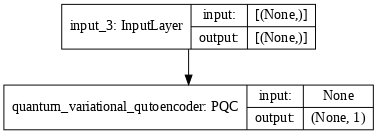

In [ ]:
model = create_model(qubits,sympy.symbols('encoder:'+num_symbols),layers)
tf.keras.utils.plot_model(model,
                          show_shapes=True,
                          show_layer_names=True,
                          dpi=70)

In [ ]:
# Hypeyparameters
batch = 20
epochs = 10

# **Training the Model**

In [ ]:
H = model.fit(x=train_quantum_data,
          y=y_train,
          batch_size=batch,
          # verbose=verbose,
          epochs = epochs,
          validation_data = (test_quantum_data,y_test))

Epoch 1/10
5/5 [==============================] - 32s 7s/step - loss: 0.9807 - accuracy: 0.4571 - val_loss: 0.9217 - val_accuracy: 0.5400
Epoch 2/10
5/5 [==============================] - 30s 6s/step - loss: 0.8879 - accuracy: 0.3987 - val_loss: 0.7717 - val_accuracy: 0.5400
Epoch 3/10
5/5 [==============================] - 30s 6s/step - loss: 0.7132 - accuracy: 0.4458 - val_loss: 0.5508 - val_accuracy: 0.4900
Epoch 4/10
5/5 [==============================] - 30s 6s/step - loss: 0.4949 - accuracy: 0.5157 - val_loss: 0.3550 - val_accuracy: 0.4800
Epoch 5/10
5/5 [==============================] - 30s 6s/step - loss: 0.3042 - accuracy: 0.5572 - val_loss: 0.1949 - val_accuracy: 0.4600
Epoch 6/10
5/5 [==============================] - 31s 6s/step - loss: 0.1643 - accuracy: 0.5158 - val_loss: 0.1057 - val_accuracy: 0.4600
Epoch 7/10
5/5 [==============================] - 30s 6s/step - loss: 0.0825 - accuracy: 0.5478 - val_loss: 0.0576 - val_accuracy: 0.4600
Epoch 8/10
5/5 [==================

Text(0, 0.5, 'Loss')

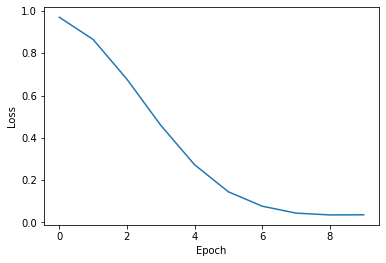

In [ ]:
plt.plot(H.history['loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')

# **Conclusion**
1. The image size is 32x32(i.e 1024 features) per sample which we reduced using PCA to 10 features. It is evident reducing features substantially still captures most of the variance(~ 97%) of the dataset. 
2. The circuit depth can become really large if more and more qubits are considered which may introduce errors hence the right tradeoff between number of qubits and encoding performance needs to be found out.
3. From the training loss it is evident that the circuit learns and encodes the 10 feature data into 4 features(latent space).

# **References**
[1]-[Quantum autoencoders for efficient compression of quantum data
Jonathan Romero,1
Jonathan P. Olson,1
and Alan Aspuru-Guzik1,](https://arxiv.org/pdf/1612.02806.pdf)